In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

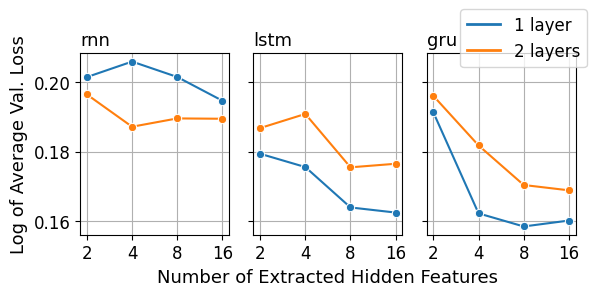

In [18]:
loss_type = 'square'

# %%
# Create a single figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True)

# Plot the data for each model
for i, model in enumerate(['rnn', 'lstm', 'gru']):
    stat_df = pd.read_csv(f"../model/{model}/stat.csv")
    stat_df = stat_df[stat_df['loss_type'] == loss_type]
    stat_hidden_size_df = stat_df.groupby(['num_layers', 'hidden_size'])['val_loss'].mean().reset_index()
    stat_hidden_size_df['hidden_size'] = stat_hidden_size_df['hidden_size'].astype(str)
    
    # Apply log transformation to val_loss
    stat_hidden_size_df['log_val_loss'] = np.log10(stat_hidden_size_df['val_loss'])

    # Get the unique number of layers
    num_layers_unique = stat_hidden_size_df['num_layers'].unique()

    # Use a color palette with the same number of colors as unique num_layers
    palette = sns.color_palette("tab10", n_colors=len(num_layers_unique))

    # Plot on the i-th axis (subplot), disable the legend for each individual plot
    sns.lineplot(data=stat_hidden_size_df, x='hidden_size', y='log_val_loss', hue='num_layers', 
                 marker='o', palette=palette, ax=axes[i], legend=False)

    # Add labels and title for each subplot
    if i==1:
        axes[i].set_xlabel("Number of Extracted Hidden Features", fontsize=13)
    else:
        axes[i].set_xlabel("")
    axes[i].set_ylabel("Log of Average Val. Loss", fontsize=13)
    axes[i].set_title(f"{model}", loc='left', fontsize=13)
    axes[i].grid(True)

    axes[i].tick_params(axis='x', labelsize=12)  # Increase x-axis tick label size
    axes[i].tick_params(axis='y', labelsize=12)  # Increase y-axis tick label size

# Manually create a single legend outside the subplots
handles = [plt.Line2D([0], [0], color=palette[i], lw=2) for i in range(len(num_layers_unique))]
labels = [f"{layer} layer{'s' if layer > 1 else ''}" for layer in num_layers_unique]

# Add the global legend at the top center of the figure
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.00, 1), ncol=1, fontsize=12)

# Adjust layout and ensure the legend doesn't overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the space needed for the legend
plt.savefig("pdfs/n_extracted_features.pdf")